In [1]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# select device: change to 'cpu' if there's no GPU device
device = 'cpu'

dtype = 'double'

if device == 'gpu':
    torch.cuda.set_device(0)
    
    if dtype=='float':
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        dtype_ = torch.float32
    else:
        torch.set_default_tensor_type(torch.cuda.DoubleTensor)
        dtype_ = torch.double



if device == 'cpu':
    torch.set_default_tensor_type(torch.DoubleTensor)
    dtype_ = torch.double

In [3]:
hamiltorch.set_random_seed(123)

In [4]:
import numpy as np

In [5]:
# N,P = int(200),5
torch.manual_seed(123)

In [6]:
from sklearn import cluster, datasets, mixture


In [7]:
n_samples = 300

blobs = datasets.make_blobs(n_samples=n_samples, random_state=0,shuffle=False)


In [8]:
y = blobs[0]

In [9]:
from scipy.spatial import distance


In [10]:
D = distance.squareform(distance.pdist(y))

In [11]:
logD = np.log(D)
np.fill_diagonal(logD,0)

/home/shared/anaconda3/envs/leo/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [12]:
D_tc = torch.tensor(D)
logD_tc = torch.tensor(logD)

In [13]:
svdD = np.linalg.svd(D)

In [14]:
p = 2

In [15]:
trunc = p +2

In [17]:
n = y.shape[0]

In [18]:
K = 3

In [19]:
from torch.nn.functional import softplus

In [21]:
P = n*(K-1)+K+K

In [22]:
def log_prob(theta, t = 1E-1):
    
    
    idx = 0
    idx1 = n*(K-1)
    
    W0 = theta[ idx: idx1].reshape([n,(K-1)])
    W1 = torch.hstack([W0,torch.zeros(n,1)])
    W = torch.softmax((W1)/t,1)
    
    prior_W0 =  - 1/9.0/2.0 * (W0**2).sum()
    
    
    idx = idx1
    idx1 += K
    sigma = softplus(theta[ idx: idx1])
    
    
    idx = idx1
    idx1 += K
    alpha = softplus(theta[ idx: idx1])
    
    prior_alpha =  (- alpha).sum()
    
    n_h = torch.diag(W.T@W)
    
    prior_sigma = -1000*(sigma**2).sum()
  
    loglik = torch.trace(W.T@logD_tc@W*(alpha-1)/(n_h)) - torch.trace(W.T@D_tc@W/(n_h*sigma)) +  \
        (- n_h* ( alpha* torch.log(sigma) + torch.lgamma(alpha))).sum() + prior_sigma + prior_W0 + prior_alpha

    return  loglik


In [23]:
# initialization using spectral clustering
scFit = cluster.spectral_clustering(     logD -D +1E6 , n_clusters=K )

In [24]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])


In [25]:
W_init  = torch.tensor(one_hot(scFit,3))

In [27]:
W_init = torch.log(W_init+0.1)

In [28]:
W_init -= torch.reshape(W_init[:,K-1],[n,1])

In [29]:
theta = torch.randn(P)

theta[:(n*(K-1))] = (W_init[:,:(K-1)]).flatten()

theta= theta.requires_grad_()


optimizer = torch.optim.LBFGS([theta], lr=1E-1)


def closure():
    optimizer.zero_grad()
    loss =  -log_prob(theta)
    loss.backward()
    return loss

for t in range(100):
          
    optimizer.step(closure)



In [31]:
from torch.autograd import grad


In [32]:
from torch.autograd.functional import hessian

In [33]:
idx = 0
idx1 = n*(K-1)

t = 1E-1

W0 = theta[ idx: idx1].reshape([n,(K-1)])
W1 = torch.hstack([W0,torch.zeros(n,1)])
W = torch.softmax((W1)/t,1)

idx = idx1
idx1 += K
sigma = softplus(theta[ idx: idx1])


idx = idx1
idx1 += K
alpha = softplus(theta[ idx: idx1])


n_h = torch.diag(W.T@W)

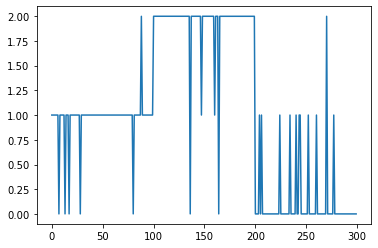

In [34]:
W_np = W.detach().cpu().numpy()

plt.plot((W_np@ np.diag(np.arange(3))).sum(1))

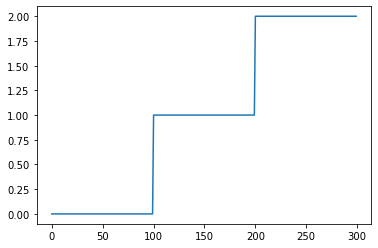

In [35]:
plt.plot(blobs[1])

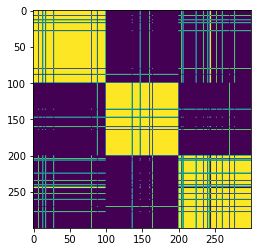

In [36]:
plt.imshow((W@W.T).detach().numpy())

In [37]:
from torch.autograd.functional import hessian

In [38]:
H = hessian(log_prob,theta).diagonal()

In [39]:
inv_mass = 1.0/H.abs()

In [46]:
# HMC NUTS

step_size = 5E-2
hamiltorch.set_random_seed(123)
params_init = theta

num_samples = 3000 # For results in plot num_samples = 12000
L = 100
burn = 1000 # For results in plot burn = 2000

params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob,
                                    params_init=params_init, num_samples=num_samples,
                                    step_size=step_size, num_steps_per_sample=L,
                                    desired_accept_rate=0.6,
                                    sampler=hamiltorch.Sampler.HMC_NUTS,burn=burn,
                                    inv_mass = inv_mass
                                   )




Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.05277268961071968--- |  999/3000 | 10.75       
0d:00:04:44 | 0d:00:00:00 | #################### | 3000/3000 | 10.55       
Acceptance Rate 0.58


In [47]:


def extractW2(i):
    idx = 0
    idx1 = n*(K-1)

    t = 1E-1

    W0 = theta[ idx: idx1].reshape([n,(K-1)])
    W1 = torch.hstack([W0,torch.zeros(n,1)])
    W = torch.softmax((W1)/t,1)
    return W@W.T

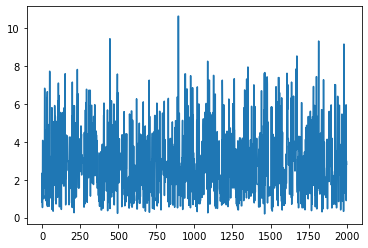

In [48]:

param_trace = torch.vstack(params_hmc_nuts)

trace_np = param_trace.detach().cpu().numpy()

plt.plot(trace_np[:,1]*1)

# plt.scatter(trace_np[:,0],trace_np[:,1])



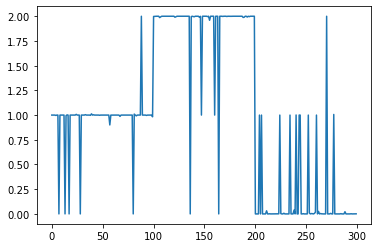

In [49]:
theta = param_trace[1, ]

idx = 0
idx1 = n*(K-1)

t = 1E-1

W0 = theta[ idx: idx1].reshape([n,(K-1)])
W1 = torch.hstack([W0,torch.zeros(n,1)])
W = torch.softmax((W1)/t,1)

W_np = W.detach().numpy()


plt.plot((W_np@ np.diag(np.arange(3))).sum(1))

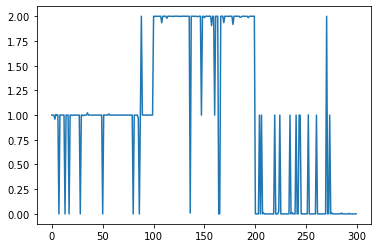

In [50]:
theta = param_trace[99, ]

idx = 0
idx1 = n*(K-1)

t = 1E-1

W0 = theta[ idx: idx1].reshape([n,(K-1)])
W1 = torch.hstack([W0,torch.zeros(n,1)])
W = torch.softmax((W1)/t,1)

W_np = W.detach().numpy()

plt.plot((W_np@ np.diag(np.arange(3))).sum(1))

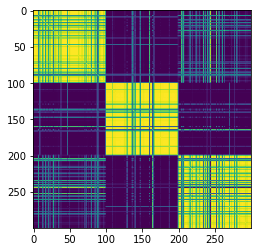

In [51]:
param_trace = torch.vstack(params_hmc_nuts)

trace_np = param_trace.detach().cpu().numpy()

# plt.plot(trace_np[:,1])

# plt.plot(trace_np[:,3])

def extractW2(i):
    theta = param_trace[i, ]
    idx = 0
    idx1 = n*(K-1)

    t = 1E-1

    W0 = theta[ idx: idx1].reshape([n,(K-1)])
    W1 = torch.hstack([W0,torch.zeros(n,1)])
    W = torch.softmax((W1)/t,1)
    return W@W.T

W2 = torch.zeros([n,n])

for i in range(param_trace.shape[0]):
    W2 += extractW2(i)

W2_var = (W2/param_trace.shape[0])

plt.imshow(W2_var.detach().numpy(),vmin=0,vmax=1)

In [52]:
# plt.plot(param_trace[:,4])

In [53]:
def extractC(i):
    theta = param_trace[i, ]
    idx = 0
    idx1 = n*(K-1)

    t = 1E-1

    W0 = theta[ idx: idx1].reshape([n,(K-1)])
    W1 = torch.hstack([W0,torch.zeros(n,1)])
    C = torch.softmax((W1)/t,1)@ np.arange(K)
    return C

In [54]:
C_trace = torch.stack([extractC(i) for i in range(2000)]).round()

In [55]:
from pylab import rcParams

rcParams['figure.figsize'] = 5, 4
rcParams['figure.dpi'] = 300

In [56]:
from statsmodels.tsa.stattools import acf

In [57]:
C_trace.shape

torch.Size([2000, 300])

In [58]:
acf_mat = np.vstack([ acf(param_trace[:,i], fft=False, nlags=40) for i in range(300)])

acf_mat[np.isnan(acf_mat)]=0

acf_mat[:,0]=1

In [59]:
import pymc3 as pm3
import arviz

In [60]:
P

606

In [61]:
ess = np.stack([arviz.ess(param_trace[:,i].numpy()) for i in range(P)])

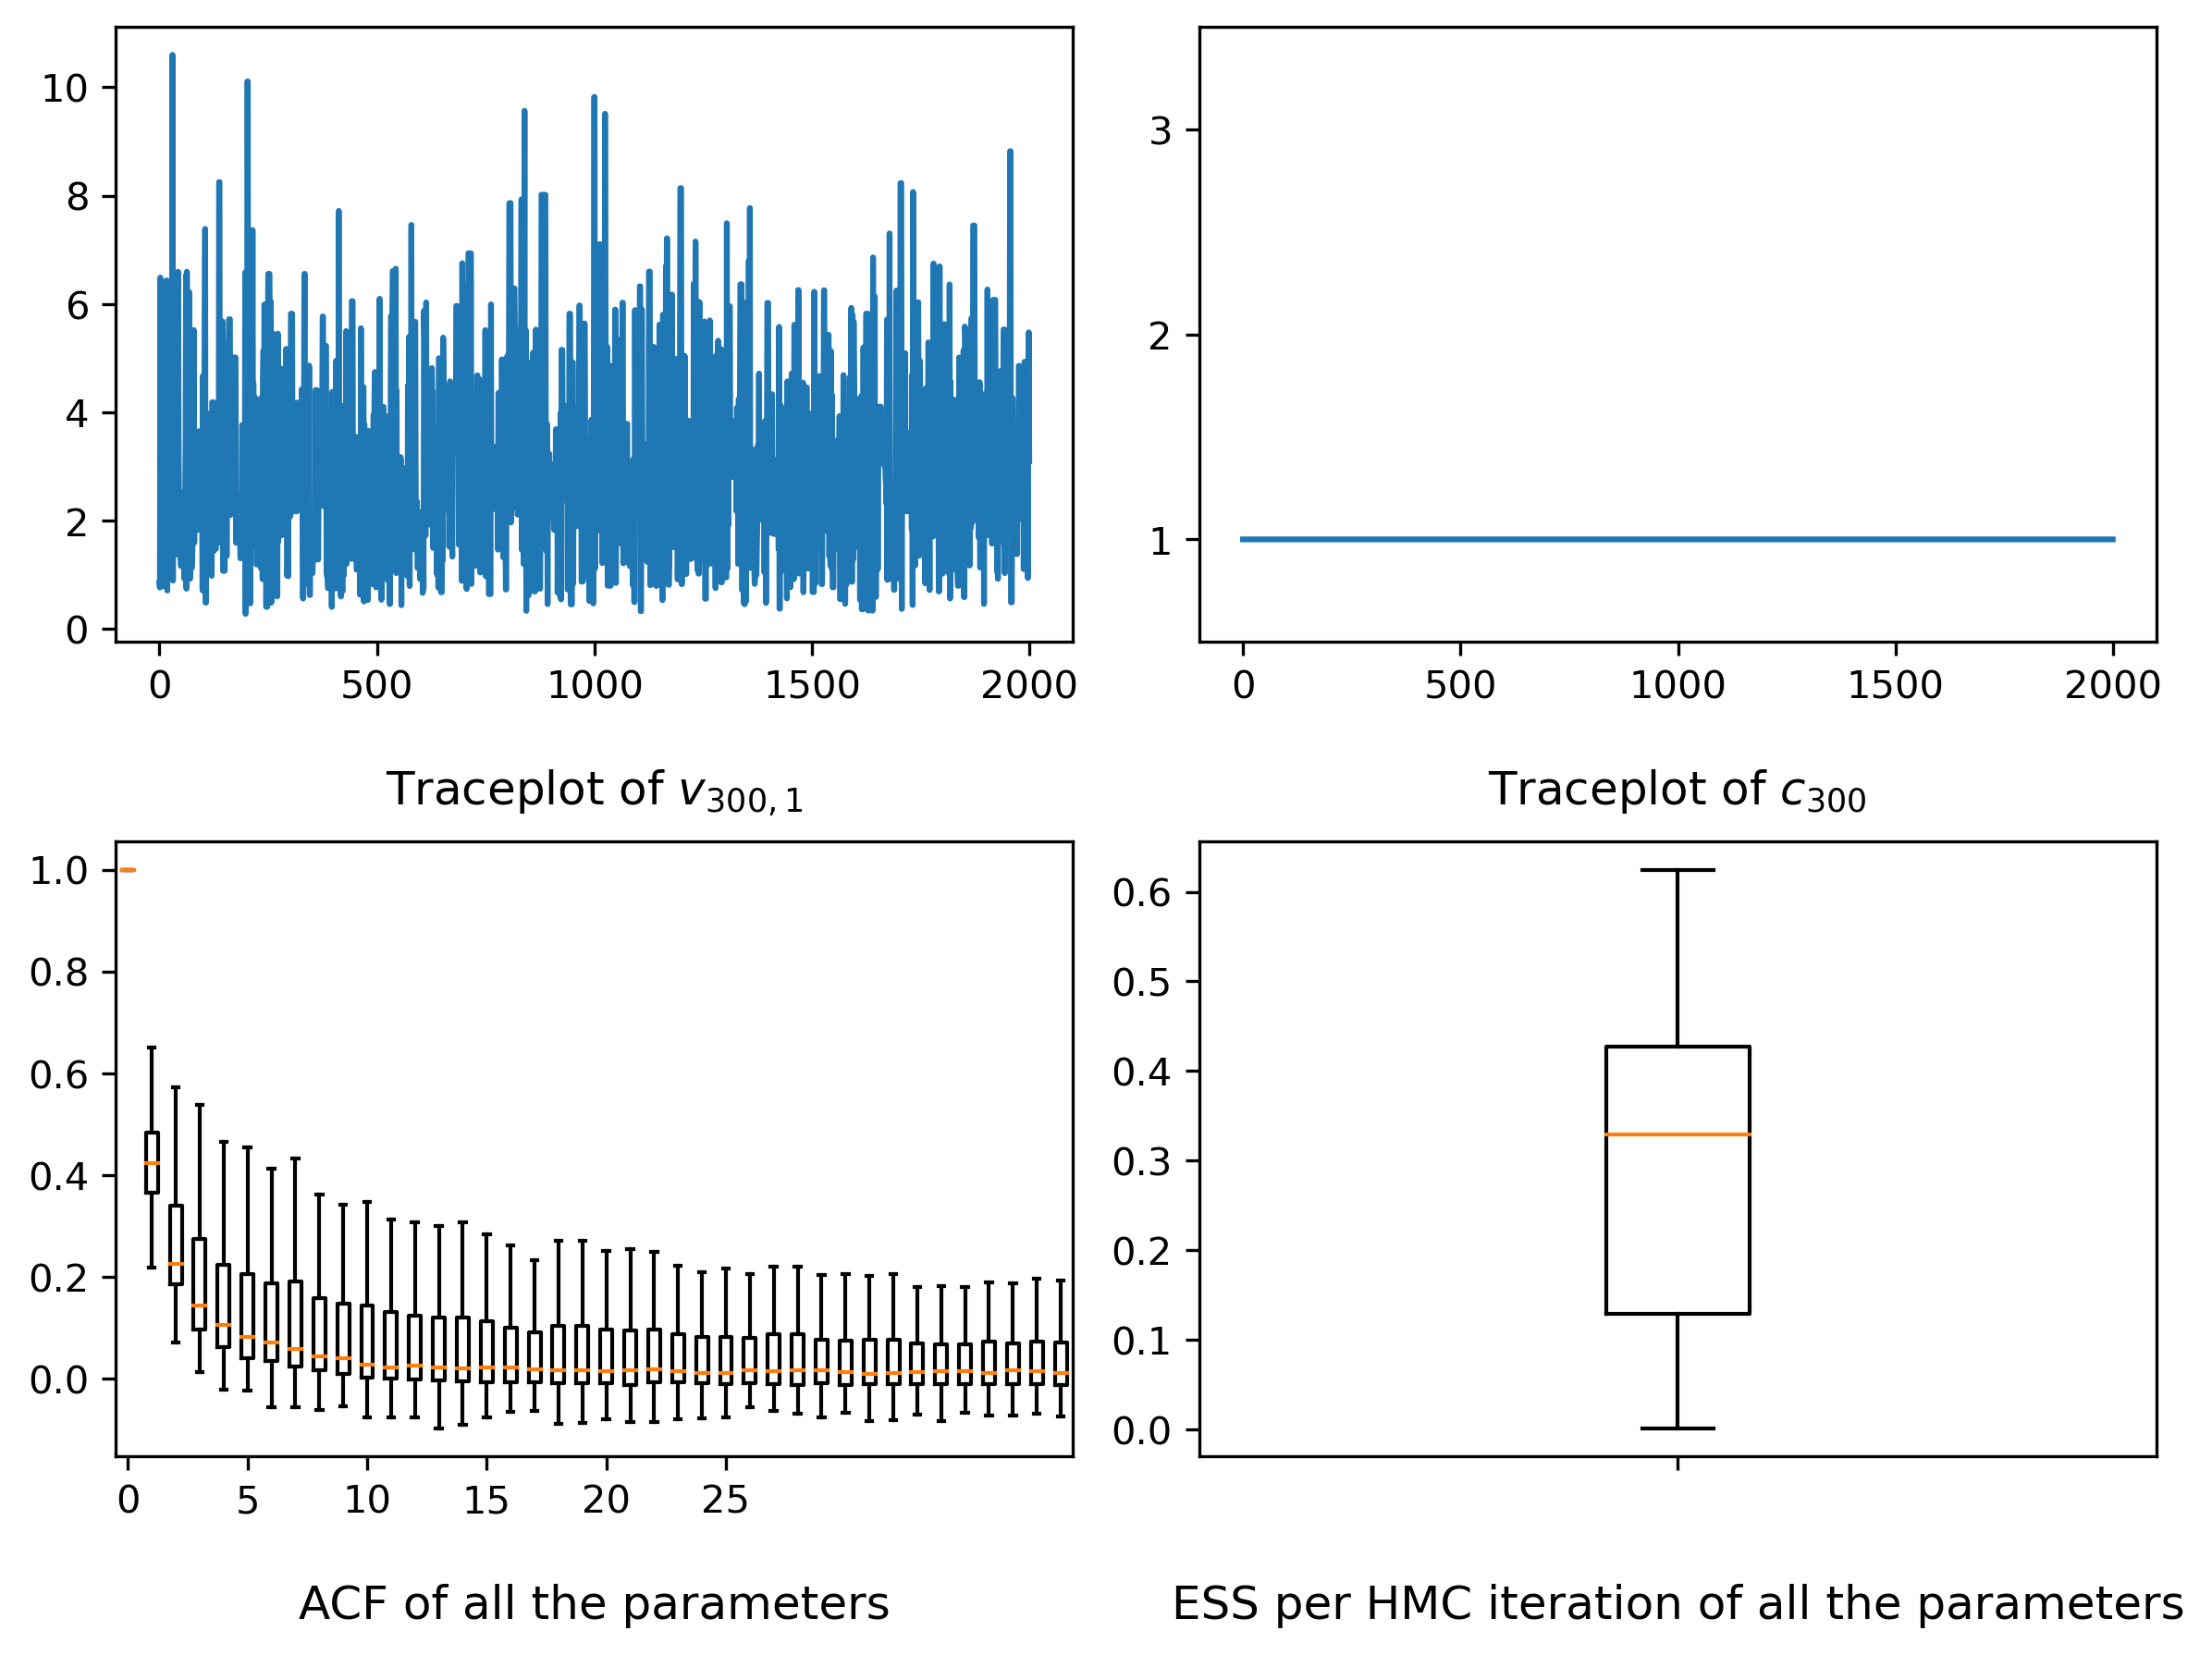

In [62]:
fig, ax = plt.subplots(2,2, gridspec_kw={'width_ratios': [1, 1] })
fig.set_size_inches([8,6])

ax[0,0].plot(param_trace[:,(299)*(K-1)])
ax[0,0].set_title("Traceplot of $v_{300,1}$", y=-0.3)
ax[0,1].plot(np.arange(2000),C_trace[:,299]+1)
ax[0,1].set_title("Traceplot of $c_{300}$", y=-0.3)
ax[0,1].set_ylim([0.5,3.5])
ax[0,1].set_yticks([1,2,3])

ax[1,0].boxplot(acf_mat[:,:40],  showfliers=False, )
ax[1,0].set_xticks( np.arange(6)*5+1)
ax[1,0].set_xticklabels(np.arange(6)*5)
ax[1,0].set_title("ACF of all the parameters", y=-0.3)

ax[1,1].boxplot(ess/2000,  showfliers=False, )
ax[1,1].set_xticks( [1])
ax[1,1].set_xticklabels([""])
ax[1,1].set_title("ESS per HMC iteration of all the parameters", y=-0.3)
fig.tight_layout(pad=1)
# fig.savefig("benchmark_hmc.png")

In [63]:
idx = 0
idx1 = n*(K-1)



W0 = theta[ idx: idx1].reshape([n,(K-1)])
W1 = torch.hstack([W0,torch.zeros(n,1)])
W = torch.softmax((W1)/t,1)

prior_W0 =  - 1/9.0/2.0 * (W0**2).sum()


idx = idx1
idx1 += K
sigma = softplus(theta[ idx: idx1])


idx = idx1
idx1 += K
alpha = softplus(theta[ idx: idx1])

prior_alpha =  (- alpha).sum()


n_h = torch.diag(W.T@W)
    

  

In [71]:
mapC = C_trace.mode(0)[0]

In [72]:
uncertainty = ((C_trace == mapC)*1.0).mean(0)

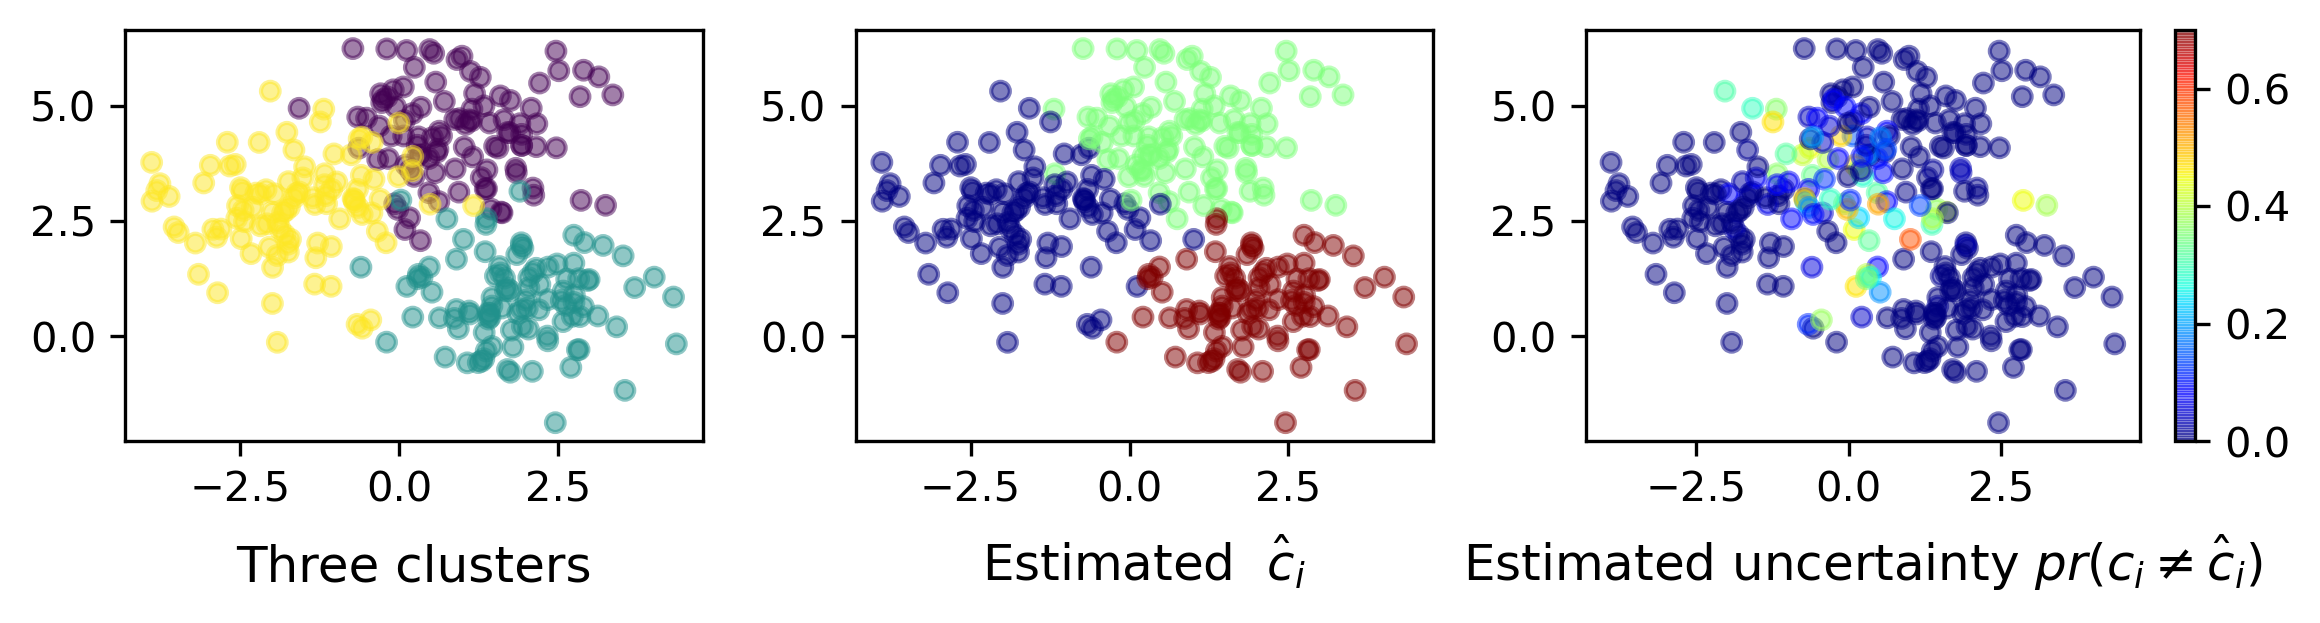

In [101]:

fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1, 1,1.2] })
fig.set_size_inches([8,2.5])

ax[0].scatter(blobs[0][:,0],blobs[0][:,1], c=blobs[1], alpha=0.5, s=20)
ax[0].set_title("Three clusters", y= -0.4)


ax[1].scatter(blobs[0][:,0],blobs[0][:,1], c=mapC.numpy(), alpha=0.5, s=20, cmap='jet')
ax[1].set_title("Estimated  $\hat c_i$", y= -0.4)


im1 = ax[2].scatter(blobs[0][:,0],blobs[0][:,1], c=1-uncertainty, alpha=0.5, s=20, cmap='jet', vmin=0,  vmax=0.7)
fig.colorbar(im1 ,ax=ax[2])
ax[2].set_title("Estimated uncertainty $pr(c_i \\neq \hat c_i)$", y= -0.4)


fig.tight_layout(pad=1.5)
fig.savefig("benchmark_hmc_plot.png")